In [13]:
import os
import numpy as np
import pandas as pd
import json
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MaxAbsScaler
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

from library.utils import *
from library.model import *
from library.outlier import *
from library.active_learning import *

In [22]:
##### INPUT
#parameter_file = "data\\parameter_lipase_modify_name.csv"
data_folder = "data\\lea\\data"
# data_folder = "data\\lea_result"
target = ['yield_1','yield_2','yield_3','yield', 'yield_std']
name_list = ['yield_1','yield_2','yield_3']
parameter_file = "data\\lea\\params.csv"


Import data

In [15]:
element_list, element_max, sampling_condition = import_parameter(parameter_file, verbose = True)

Number of metabolites : 8
Number of combinations - poolsize : 1679616
Possible concentrations: 


,Mg-glutamate,K-glutamate,Amino acid,Spermidine,3-PGA,NTPs,PEG-8000,DNA
0,0.00,0.0,0.0000,0.000,0.00,0.0000,0.00,1.0
1,1.53,40.8,0.3825,0.255,7.65,0.3825,0.51,2.8
2,2.97,79.2,0.7425,0.495,14.85,0.7425,0.99,4.6
3,4.50,120.0,1.1250,0.750,22.50,1.1250,1.50,6.4
4,6.03,160.8,1.5075,1.005,30.15,1.5075,2.01,8.2
5,9.00,240.0,2.2500,1.500,45.00,2.2500,3.00,10.0


In [23]:
data = import_data(data_folder, verbose = False)
data = data.iloc[:,1:]
check_column_names(data,target,element_list)
#pd.set_option('display.max_rows', None) 
data

All column names matched!


,Mg-glutamate,K-glutamate,Amino acid,Spermidine,3-PGA,NTPs,PEG-8000,DNA,yield_1,yield_2,yield_3,yield,yield_std
0,6.03,240.0,2.2500,1.005,0.00,1.1250,0.99,6.4,0.031316,0.027513,-0.068428,-3.199765e-03,0.056522
1,9.00,0.0,0.7425,0.000,0.00,0.7425,0.99,8.2,0.024279,-0.161239,0.024977,-3.732772e-02,0.107311
2,2.97,160.8,1.5075,1.005,7.65,1.1250,1.50,6.4,0.271092,-0.015076,-0.008478,8.251255e-02,0.163348
3,4.50,160.8,0.0000,0.255,14.85,0.3825,1.50,10.0,-0.002863,-0.092491,-0.079632,-5.832888e-02,0.048463
4,9.00,40.8,0.3825,0.255,30.15,0.0000,2.01,2.8,-0.126154,-0.361608,-0.196143,-2.279682e-01,0.120910
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,4.50,0.0,2.2500,1.500,22.50,1.5075,0.51,4.6,0.533585,0.467192,0.534257,5.116779e-01,0.038528
99,4.50,120.0,1.1250,0.495,7.65,0.7425,0.51,4.6,-0.130397,-0.121548,-0.011661,-8.786849e-02,0.066146
100,0.00,0.0,0.0000,0.000,0.00,0.0000,0.00,0.0,0.342427,0.298803,0.138823,2.600176e-01,0.107200
101,4.00,120.0,1.5000,1.000,30.00,1.5000,2.00,0.0,-0.068894,-0.032722,0.101616,1.896631e-16,0.089842


Remove outliers

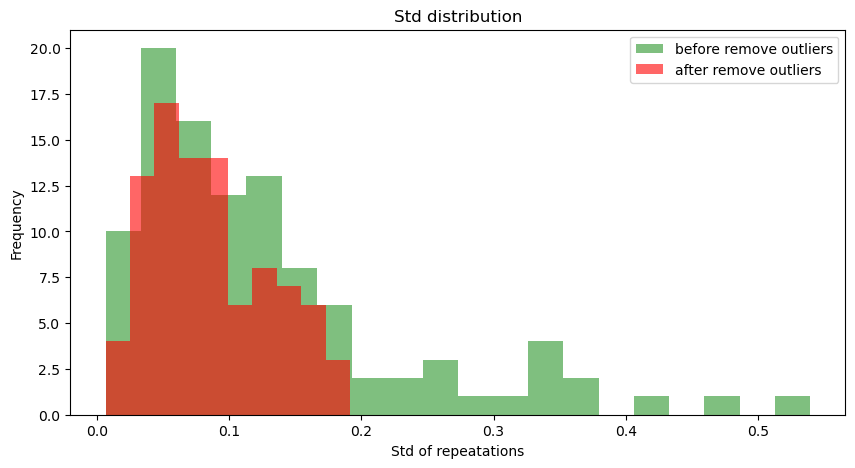

In [24]:
yield_array = np.array(data[name_list])
mean_0 = np.mean(yield_array, axis = 1)
std_0 = np.std(yield_array, axis = 1)

data_no = remove_outlier(yield_array)
std = []
mean = []
for i in data_no:
    std.append(np.std(i))
    mean.append(np.mean(i))

std = np.array(std)

# Plot histograms side by side
plt.figure(figsize=(10, 5))
plt.hist(std_0, bins=20, color='green', alpha=0.5, label='before remove outliers')
plt.hist(std, bins=10, color='red', alpha=0.6, label='after remove outliers')

plt.title('Std distribution')
plt.xlabel('Std of repeatations')
plt.ylabel('Frequency')
plt.legend()

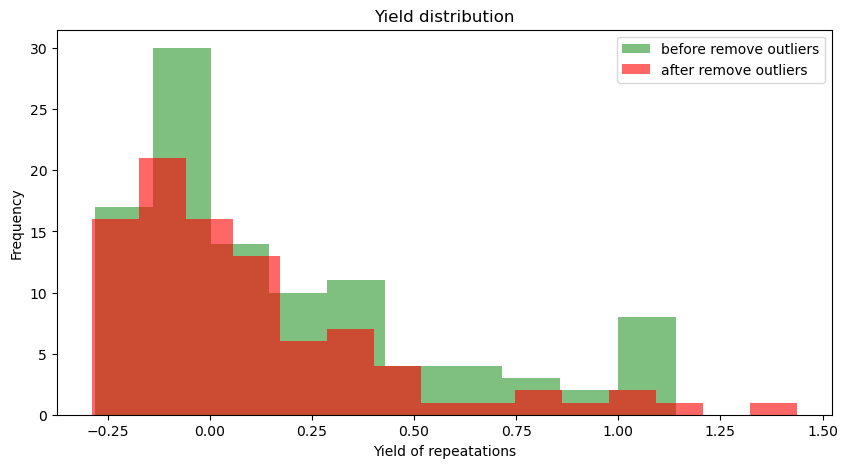

In [18]:
# Plot yields
plt.figure(figsize=(10, 5))
plt.hist(mean_0, bins=10, color='green', alpha=0.5, label='before remove outliers')
plt.hist(mean, bins=15, color='red', alpha=0.6, label='after remove outliers')

plt.title('Yield distribution')
plt.xlabel('Yield of repeatations')
plt.ylabel('Frequency')
plt.legend()

Preprocess: splitting, flatten and normalize

In [19]:
no_element = len(element_list)
medium = data.iloc[:,0:no_element]
X_train, X_test, y_train, y_test = split_and_flatten(medium, data_no, ratio = 0.2, flatten = False)

scaler = MaxAbsScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

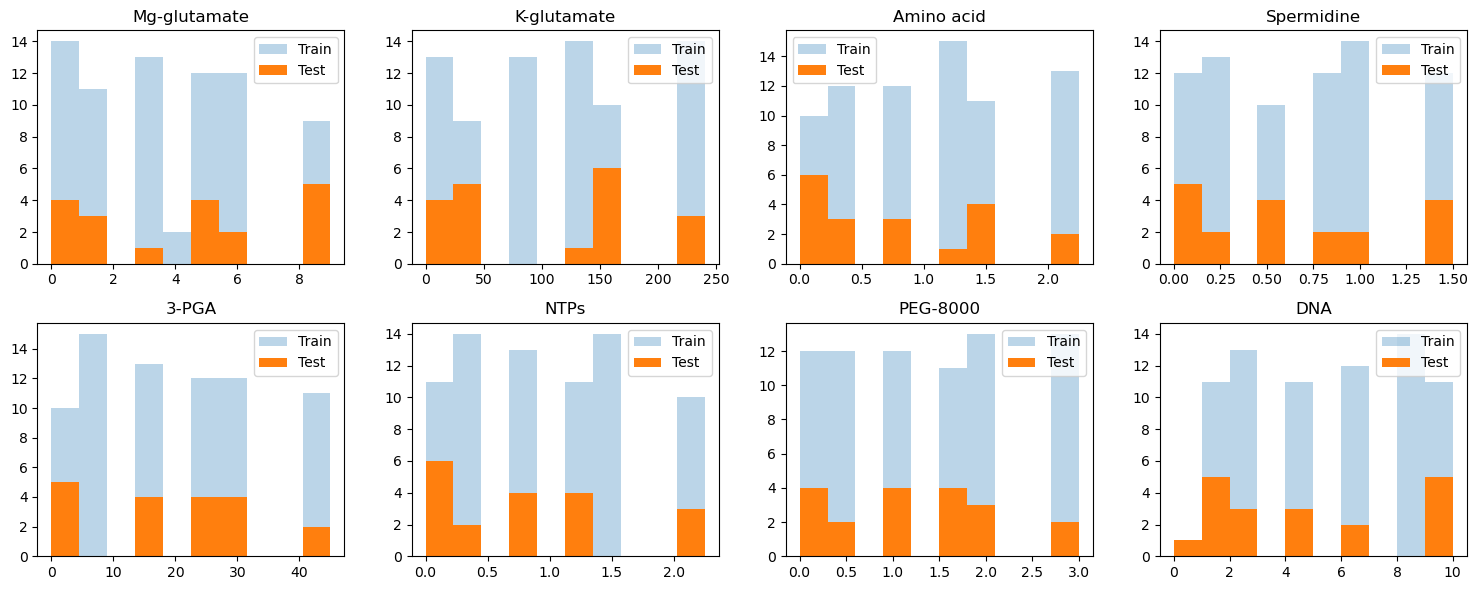

In [20]:
# histogram of X
train = pd.DataFrame(X_train, columns= element_list)
test = pd.DataFrame(X_test, columns=element_list)

# Plot histograms for each column in both DataFrames on the same figure
nrows = int(np.sqrt(no_element))
ncols = no_element//nrows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6))

for i, column in enumerate(element_list):
    row = i // ncols
    col = i % ncols
    axes[row, col].hist(train[column], alpha=0.3, label='Train', bins=10)
    axes[row, col].hist(test[column], alpha=1, label='Test', bins=10)
    axes[row, col].set_title(column)
    axes[row, col].legend()

plt.tight_layout()
plt.show()


Modelling

In [25]:
gp_param = {
    'kernel': [
        DotProduct() + WhiteKernel(), 
        RBF() + WhiteKernel(),
#               RBF(),
#                1.0 * RBF(length_scale=1.0),
        1.0 * C(1.0) * RBF(length_scale=0) + WhiteKernel(),
        1.0 * Matern(length_scale=1, nu=1.5),
                ]
                }

mlp_param = {
    'hidden_layer_sizes' : [(32,64),(64),(32),(10),],
    'early_stopping' : [True],
    'learning_rate' : ["adaptive"], 
    'max_iter' : [2000],
}

xgb_param = {
    'objective': ['reg:squarederror'],
    'learning_rate': [0.01, 0.1],  # Step size shrinkage used to prevent overfitting
    'n_estimators': [10, 50, 100, 500],       # Number of boosting rounds
    'max_depth': [5, 7, 10],               # Maximum depth of a tree
}

rf_param = {
    'n_estimators': [10, 50, 100],
    'max_depth': [7, 10, 20],
}

param_dict = {
    'gp' : gp_param,
    'mlp': mlp_param,
    'xgboost' : xgb_param,
    'rf' : rf_param
}

model_list = ["gp",'mlp','xgboost','rf']
no_rep = 30 
result = pd.DataFrame(columns = model_list)
for i in range(no_rep):
    X_train, X_test, y_train, y_test = split_and_flatten(medium, yield_array, ratio = 0.2, flatten = True)

    scaler = MaxAbsScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)
    res = []
    for name in model_list:
        model = BayersianModels(model_type = name, params= param_dict[name])
        model.train(X_train_norm, y_train)
        y_pred, std_pred = model.predict(X_test_norm)
        res.append(r2_score(y_test, y_pred))
    
    result = pd.concat([result, pd.DataFrame([res], columns=model_list)], axis=0)

Best hyperparameter found: {'kernel': RBF(length_scale=1) + WhiteKernel(noise_level=1)}
Best hyperparameter found: {'early_stopping': True, 'hidden_layer_sizes': (32, 64), 'learning_rate': 'adaptive', 'max_iter': 2000}
Best hyperparameter found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'objective': 'reg:squarederror'}
Best hyperparameter found: {'max_depth': 20, 'n_estimators': 100}
Best hyperparameter found: {'kernel': RBF(length_scale=1) + WhiteKernel(noise_level=1)}
Best hyperparameter found: {'early_stopping': True, 'hidden_layer_sizes': 10, 'learning_rate': 'adaptive', 'max_iter': 2000}
Best hyperparameter found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'objective': 'reg:squarederror'}
Best hyperparameter found: {'max_depth': 7, 'n_estimators': 100}
Best hyperparameter found: {'kernel': RBF(length_scale=1) + WhiteKernel(noise_level=1)}
Best hyperparameter found: {'early_stopping': True, 'hidden_layer_sizes': (32, 64), 'learning_rate': 'adaptive

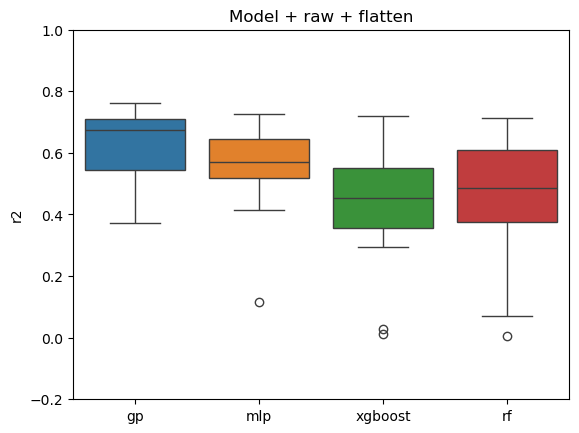

In [26]:
sns.boxplot(data = result)
# Show the plot
plt.title('Model + raw + flatten')
plt.ylim(top = 1, bottom = -0.2)
plt.ylabel('r2')
plt.show()

In [ ]:
# modelling 
gp_param = {
    'kernel': [
#        DotProduct() + WhiteKernel(), 
#        RBF() + WhiteKernel(),
#               RBF(),
#                1.0 * RBF(length_scale=1.0),
#        1.0 * C(1.0) * RBF(length_scale=0) + WhiteKernel(),
        1.0 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=0.2),
#        1.0 * Matern(length_scale=1, nu=2.5)
                ]
                }

param_dict = {
    'gp' : gp_param,
    'mlp': mlp_param,
    'xgboost' : xgb_param,
    'rf' : rf_param
}
pd.set_option('display.max_rows', None) 
column = ['Marten', 'DotProduct', 'RBF', 'C']
repeat = 30
result = pd.DataFrame(columns = column)
for i in range(repeat):
    res = []
    X_train, X_test, y_train, y_test = split_and_flatten(medium, yield_array, ratio = 0.2, flatten = True)

    scaler = MaxAbsScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)

    model = BayersianModels(model_type = 'gp', params= {'kernel': [1.0 * Matern(length_scale=1, nu=1.5) + WhiteKernel()]})
    model.train(X_train_norm, y_train)
    y_pred, std_pred = model.predict(X_test_norm)
    res.append(r2_score(y_test, y_pred))

    model = BayersianModels(model_type = 'gp', params= {'kernel': [DotProduct() + WhiteKernel()]})
    model.train(X_train_norm, y_train)
    y_pred, std_pred = model.predict(X_test_norm)
    res.append(r2_score(y_test, y_pred))

    model = BayersianModels(model_type = 'gp', params= {'kernel': [RBF() + WhiteKernel()]})
    model.train(X_train_norm, y_train)
    y_pred, std_pred = model.predict(X_test_norm)
    res.append(r2_score(y_test, y_pred))

    model = BayersianModels(model_type = 'gp', params= {'kernel': [1.0 * C(1.0) * RBF(length_scale=0) + WhiteKernel()]})
    model.train(X_train_norm, y_train)
    y_pred, std_pred = model.predict(X_test_norm)
    res.append(r2_score(y_test, y_pred))

    result = pd.concat([result, pd.DataFrame([res], columns=column)], axis=0)

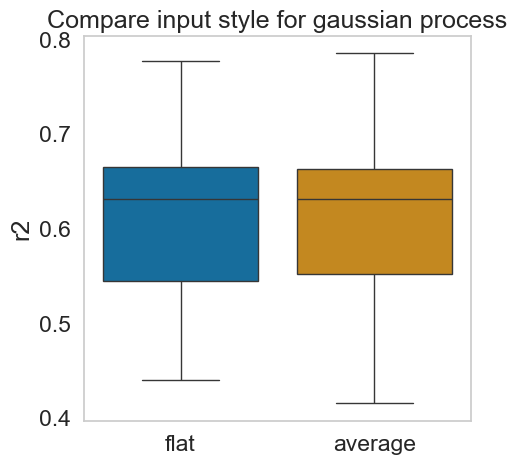

In [60]:
import scipy.stats as stats
stats.ttest_rel(result['flat'], result['average']) 
sns.boxplot(data = result)
plt.title('Compare input style for gaussian process')
plt.ylabel('r2')
plt.show()

4.402933039857026 0.015084505768121599


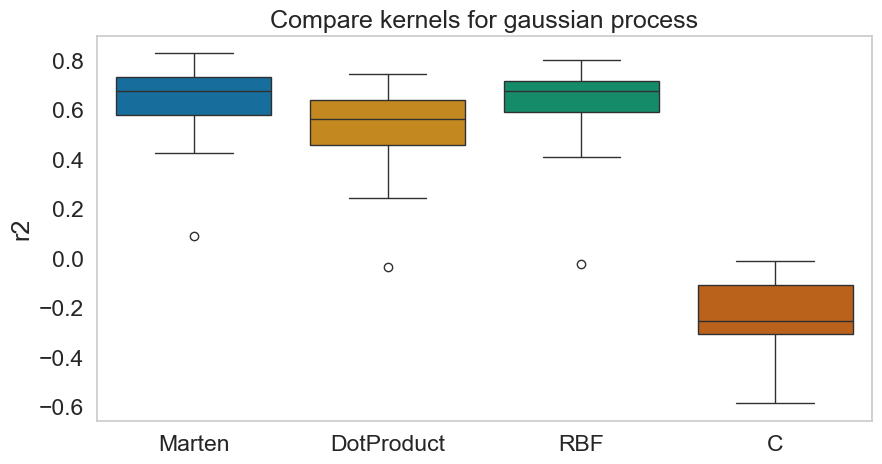

In [76]:
import scipy.stats as stats
fvalue, pvalue = stats.f_oneway(result['Marten'], result['RBF'], result['DotProduct'])
print(fvalue, pvalue)

plt.figure(figsize = [10,5])
sns.boxplot(data = result)
plt.title('Compare kernels for gaussian process')
plt.ylabel('r2')
plt.show()

In [85]:
yield_array = np.array(data[name_list])
no_element = len(element_list)
medium = data.iloc[:,0:no_element]